## Cognitive Battery Introduction: Jax-3DP3

In [13]:
import json
import os

import cog_utils as utils
import jax
import jax.numpy as jnp
import numpy as np
from PIL import Image
from tqdm import tqdm

import jax3dp3
from jax3dp3.transforms_3d import transform_from_pos, unproject_depth
from jax3dp3.viz import get_depth_image, make_gif_from_pil_images, multi_panel

from collections import deque

In [14]:
scene = "swap"
data_path = f"/home/khaledshehada/cog_jax3dp3_data/{scene}_data/videos/"
num_frames = len(os.listdir(os.path.join(data_path, "frames")))

In [15]:
width = 300
height = 300
fov = 90

intrinsics = utils.get_camera_intrinsics(width, height, fov)
renderer = jax3dp3.Renderer(intrinsics=intrinsics)

Increasing frame buffer size to (width, height, depth) = (320, 320, 1024)


In [16]:
rgb_images, depth_images, seg_maps = [], [], []
rgb_images_pil = []
for i in range(num_frames):
    rgb_path = os.path.join(data_path, f"frames/frame_{i}.jpeg")
    if not os.path.isfile(rgb_path):
        rgb_path = rgb_path.replace("jpeg", "png")
    rgb_img = Image.open(rgb_path)
    rgb_images_pil.append(rgb_img)
    rgb_images.append(np.array(rgb_img))

    depth_path = os.path.join(data_path, f"depths/frame_{i}.npy")
    depth_npy = np.load(depth_path)
    depth_images.append(depth_npy)

    seg_map = np.load(os.path.join(data_path, f"segmented/frame_{i}.npy"))
    seg_maps.append(seg_map)

with open("resources/scene_crops.json") as f:
    crops = json.load(f)[scene]

In [17]:
coord_images = []  # depth data in 2d view as images
seg_images = []  # segmentation data as images

for frame_idx in tqdm(range(num_frames), desc="Loading frames"):
    coord_image = np.array(unproject_depth(depth_images[frame_idx], intrinsics))
    segmentation_image = seg_maps[frame_idx].copy()
    mask = np.logical_and.reduce([
        *[(coord_image[:, :, i] > crops[i][0]) for i in range(len(crops))],
        *[(coord_image[:, :, i] < crops[i][1]) for i in range(len(crops))],        
    ])
    mask = np.invert(mask)

    coord_image[mask, :] = 0.0
    segmentation_image[mask, :] = 0.0
    coord_images.append(coord_image)
    seg_images.append(segmentation_image)

coord_images = np.stack(coord_images)
seg_images = np.stack(seg_images)

Loading frames: 100%|██████████| 239/239 [00:06<00:00, 34.17it/s]


In [18]:
# Load meshes
meshes = []
meshes_path = data_path.replace("videos", "meshes")
for mesh_name in os.listdir(meshes_path):
    if not mesh_name.endswith(".obj"): continue
    mesh_path = os.path.join(meshes_path, mesh_name)
    renderer.add_mesh_from_file(mesh_path, force="mesh")
    meshes.append(mesh_name.replace(".obj", ""))
print("Found meshes:", meshes)

Found meshes: ['apple', 'mug']


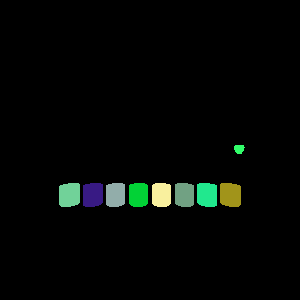

In [19]:
start_t = 11
seg_img = seg_images[start_t]

Image.fromarray(seg_img)

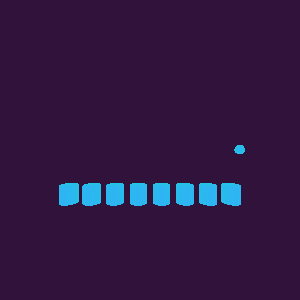

In [20]:
num_objects = 10
indices, init_poses = [], []
obj_ids = jnp.unique(seg_img.reshape(-1, 3), axis=0)
obj_ids = sorted(
    obj_ids, key=lambda x: jnp.all(seg_img == x, axis=-1).sum(), reverse=True
)
for obj_id in obj_ids[:num_objects]:
    if jnp.all(obj_id == 0):
        # Background
        continue

    obj_mask = jnp.all(seg_img == obj_id, axis=-1)
    masked_depth = coord_images[start_t].copy()
    masked_depth[~obj_mask] = 0

    object_points = coord_images[start_t][obj_mask]
    maxs = np.max(object_points, axis=0)
    mins = np.min(object_points, axis=0)
    dims = maxs - mins
    obj_center = (maxs + mins) / 2
    obj_transform = transform_from_pos(obj_center)

    best = utils.find_best_mesh(renderer, meshes, obj_transform, masked_depth)
    if best:
        indices.append(best[0])
        init_poses.append(best[1])

init_poses = jnp.array(init_poses)
rendered_image = renderer.render_multiobject(init_poses, indices)
get_depth_image(rendered_image[:, :, 2], max=5)

6. Define the liklihood methods and the proposal enumerations.

In [21]:
# Enumerating proposals
def make_unfiform_grid(n, d):
    # d: number of enumerated proposals on each dimension (x, y, z).
    # n: the minimum and maximum position delta on each dimension (x, y, z).
    return jax3dp3.make_translation_grid_enumeration(
        -d, -d, -d, d, d, d, n, n, n
    )

def prior(new_pose, prev_poses):
    new_pose = new_pose[:3,3]
    gravity_shift = jnp.array([0.0, 0.2, 0.0])
    velocity_shift = new_pose - prev_poses[:,:3,3].mean(axis=0)
    
    prev_pose = prev_poses[-1][:3,3]
    prior_shifts = gravity_shift + velocity_shift
    weight = jax.scipy.stats.norm.logpdf(new_pose - (prev_pose + prior_shifts), loc=0, scale=0.1)
    return weight.sum()

prior_parallel = jax.jit(jax.vmap(prior, in_axes=(0, None)))

def scorer(rendered_image, gt, r=0.1, op=0.005, ov=0.5):
    # Liklihood parameters
    # r: radius
    # op: outlier probability
    # ov: outlier volume
    weight = jax3dp3.likelihood.threedp3_likelihood(
        gt, rendered_image, r, op, ov
    )
    return weight
scorer_parallel = jax.jit(jax.vmap(scorer, in_axes=(0, None)))

In [22]:
pose_estimates = init_poses.copy()
t = start_t
gt_image = jnp.array(coord_images[t])

translation_deltas = make_unfiform_grid(7, 0.05)
translation_deltas_full = jnp.tile(
    jnp.eye(4)[None, :, :],
    (translation_deltas.shape[0], pose_estimates.shape[0], 1, 1),
)
translation_deltas_full = translation_deltas_full.at[:, 0, :, :].set(translation_deltas)
translation_proposals = jnp.einsum(
    "bij,abjk->abik", pose_estimates, translation_deltas_full
)
images = renderer.render_parallel(translation_proposals, 0)
weights_new = scorer_parallel(images, gt_image)
pose_estimates = translation_proposals[jnp.argmax(weights_new)]

In [23]:
num_steps = num_frames - start_t
# num_steps = 30
iterations_per_step = 1
num_past_poses = 3
n_objects = pose_estimates.shape[0]
reward_idx = n_objects - 1

containment_relations = {}
objs_deltas = {}

inferred_poses = []
pose_estimates = init_poses.copy()
past_poses = {i: deque([pose_estimates[i]]) for i in range(pose_estimates.shape[0])}
for t in tqdm(range(start_t, start_t + num_steps)):
    gt_image = jnp.array(coord_images[t])    
    for _ in range(iterations_per_step):
        for i in range(n_objects):
            if i in set(containment_relations.values()):
                continue

            # Check for occlusion
            if i == reward_idx:
                occluded = utils.check_occlusion(renderer, pose_estimates, indices, i)
                if occluded:
                    containing_obj = utils.check_containment(renderer, pose_estimates, indices, i)
                    if containing_obj is not None:
                        containment_relations[containing_obj] = i
                        continue
            
            for d in [0.2, 0.1, 0.05]:
                translation_deltas = make_unfiform_grid(n=7, d=d)
                translation_deltas_full = jnp.tile(
                    jnp.eye(4)[None, :, :],
                    (translation_deltas.shape[0], pose_estimates.shape[0], 1, 1),
                )
                translation_deltas_full = translation_deltas_full.at[:, i, :, :].set(translation_deltas)
                translation_proposals = jnp.einsum(
                    "bij,abjk->abik", pose_estimates, translation_deltas_full
                )
                images = renderer.render_multiobject_parallel(translation_proposals.transpose((1,0,2,3)), indices)
                
                weights = scorer_parallel(images, gt_image) + prior_parallel(translation_proposals[:,i], jnp.array(past_poses[i]))
                best_weight_idx = jnp.argmax(weights)
                best_proposal = translation_proposals[best_weight_idx]
                pose_estimates = best_proposal
                
            past_poses[i].append(pose_estimates[i])
            if len(past_poses[i]) > num_past_poses:
                past_poses[i].popleft()
    
        for i, j in containment_relations.items():
            i_delta_pose = past_poses[i][-1] - past_poses[i][-2]
            new_pose_estimate = pose_estimates[j] + i_delta_pose
            pose_estimates = pose_estimates.at[j].set(new_pose_estimate)
        
    inferred_poses.append(pose_estimates.copy())

 10%|█         | 23/228 [01:09<10:02,  2.94s/it]

contained by 3


100%|██████████| 228/228 [10:08<00:00,  2.67s/it]


In [24]:
all_images = []
for t in tqdm(range(start_t, start_t + num_steps)):
    rgb_viz = Image.fromarray(rgb_images[t].astype(np.int8), mode="RGB")
    gt_depth_1 = get_depth_image(coord_images[t][:, :, 2], max=5.0)
    poses = inferred_poses[t - start_t]
    rendered_image = renderer.render_multiobject(poses, indices)
    rendered_image = get_depth_image(rendered_image[:, :, 2], max=5)

    apple_pose = poses[-1]
    rendered_apple = renderer.render_single_object(apple_pose, indices[-1])
    rendered_apple = [get_depth_image(rendered_apple[:, :, 2], max=5)]
    
    all_images.append(
        multi_panel(
            [rgb_viz, gt_depth_1, rendered_image, *rendered_apple],
            [
                f"\nRGB Image",
                f"   Frame: {t}\nActual Depth",
                "\nReconstructed Depth",
                *(["\nApple Only"] * len(rendered_apple)),
            ],
            middle_width=10,
            label_fontsize=20,
        )
    )
out_path = f"{scene}_out.gif"
make_gif_from_pil_images(all_images, out_path)
print("Saved output to:", out_path)

100%|██████████| 228/228 [00:18<00:00, 12.12it/s]


Saved output to: swap_out.gif


: 